<a href="https://colab.research.google.com/github/AcidCannon/CMPUT466-Mini-project/blob/master/task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [0]:
config = {}
config['load_data'] = True
config['training_size'] = 60000
config['test_size'] = 1000
config['validation_size'] = 1000
config['training_shuffle'] = True
config['test_shuffle'] = False
config['validation_shuffle'] = True
config['num_of_classes'] = 10
config['k'] = 1
config['device'] = 'gpu'
config['algorithm'] = 'K-nearest Neighbors'
config['is_test'] = False
config['best_k'] = -1
config['best_accuracy'] = 0
config['axis_k'] = []
config['axis_accuracy'] = []

In [0]:
def load_data(config):
  # Do not need validation set since using knn
  CIFAR10_training_set = datasets.CIFAR10('data', train=True, download=True,
                              transform=transforms.Compose([
                                transforms.Grayscale(num_output_channels=1),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))                           
                                ]))

  CIFAR10_test = datasets.CIFAR10('data', train=False, download=True,
                              transform=transforms.Compose([
                                transforms.Grayscale(num_output_channels=1), 
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))
                                ]))
  
  CIFAR10_test_set = torch.utils.data.Subset(CIFAR10_test, range(0, config['test_size']))
  CIFAR10_validation_set = torch.utils.data.Subset(CIFAR10_test, range(config['test_size'], config['test_size']+config['validation_size']))
  
  training_dataloader = torch.utils.data.DataLoader(CIFAR10_training_set, batch_size=config['training_size'], shuffle=config['training_shuffle'])
  test_dataloader = torch.utils.data.DataLoader(CIFAR10_test_set, batch_size=config['test_size'], shuffle=config['test_shuffle'])
  validation_dataloader = torch.utils.data.DataLoader(CIFAR10_validation_set, batch_size=config['validation_size'], shuffle=config['validation_shuffle'])
  
  return training_dataloader, test_dataloader, validation_dataloader

In [0]:
def knn(x_train, y_train, x_test, k, num_of_classes, device):
  y_test = np.zeros((x_test.shape[0],))
  # using tensor for hardware acceleration by using GPU support
  tensor_x_train = x_train.to(device).float()
  tensor_x_test = x_test.to(device).float()
  tensor_y_train = y_train.to(device)

  tensor_one_hot = torch.zeros(k, num_of_classes, device=device)
  for i in range(x_test.shape[0]):
    # calculate l2 norm
    tensor_x_distance = torch.norm(tensor_x_train - tensor_x_test[i, :], dim=1)
    # find top k samples' indices
    _, tensor_x_indices = torch.topk(tensor_x_distance, k, largest=False)
    # get class
    tensor_y_class = torch.gather(tensor_y_train, 0, tensor_x_indices)
    tensor_y_class = tensor_y_class.reshape((k, 1))
    # get one-hot representation
    tensor_one_hot.zero_() # in-place initialization to speed up
    one_hot = tensor_one_hot.scatter_(1, tensor_y_class, 1)
    sum_one_hot = torch.sum(one_hot, 0)
    y_test[i] = torch.argmax(sum_one_hot)
  y_test = torch.from_numpy(y_test)
  return y_test


In [0]:
def run(config):
  if config['load_data']:
    config['load_data'] = False
    config['training_dataloader'], config['test_dataloader'], config['validation_dataloader'] = load_data(config)
  
  training_dataloader, test_dataloader, validation_dataloader = config['training_dataloader'], config['test_dataloader'], config['validation_dataloader']

  x_train, y_train = None, None
  for _, (data, target) in enumerate(training_dataloader):
    x_train, y_train = data, target
    break

  x_test, y_test = None, None
  for _, (data, target) in enumerate(test_dataloader):
    x_test, y_test = data, target
    break

  x_validation, y_validation = None, None
  for _, (data, target) in enumerate(validation_dataloader):
    x_validation, y_validation = data, target
    break

  x_train = x_train.reshape((x_train.shape[0], -1))
  x_test = x_test.reshape((x_test.shape[0], -1))
  x_validation = x_validation.reshape((x_validation.shape[0], -1))
  
  if config['is_test']:
    print('Test: K: {}\t'.format(config['best_k']), end='')
    predicted_y_test = knn(x_train, y_train, x_test, config['best_k'], config['num_of_classes'], config['device'])
  else:
    print('Validation: K: {}\t'.format(config['k']), end='')
    predicted_y_test = knn(x_train, y_train, x_validation, config['k'], config['num_of_classes'], config['device'])

  correct = (y_test == predicted_y_test).numpy().astype(np.int32).sum()
  incorrect = len(y_test) - correct
  accuracy = float(correct) / len(y_test)
  print('Correct Predict: {}/{} total \tAccuracy: {:5f}'.format(correct, len(y_test), accuracy))
  if accuracy > config['best_accuracy'] and not config['is_test']:
    config['best_accuracy'] = accuracy
    config['best_k'] = config['k']
  return accuracy

In [6]:
print('Training set size: {}x{}.'.format(config['training_size'], 1024))
print('Validation set size: {}x{}.'.format(config['validation_size'], 1024))
print('Test set size: {}x{}.'.format(config['test_size'], 1024))
print('Using algorithm: {}.'.format(config['algorithm']))
if config['device'] != 'cpu' and torch.cuda.is_available():
  config['device'] = torch.device('cuda')
  print('Using GPU: {}.'.format(torch.cuda.get_device_name(0)))
else:
  config['device'] = torch.device('cpu')
  print('Using CPU.')

print("Running...")
for i in range(0, 100):
  config['k'] = i+1
  config['axis_accuracy'].append(run(config))
config['is_test'] = True
_ = run(config)

Training set size: 60000x1024.
Validation set size: 1000x1024.
Test set size: 1000x1024.
Using algorithm: K-nearest Neighbors.
Using GPU: Tesla K80.
Running...


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified
Validation: K: 1	Correct Predict: 87/1000 total 	Accuracy: 0.087000
Validation: K: 2	Correct Predict: 99/1000 total 	Accuracy: 0.099000
Validation: K: 3	Correct Predict: 111/1000 total 	Accuracy: 0.111000
Validation: K: 4	Correct Predict: 105/1000 total 	Accuracy: 0.105000
Validation: K: 5	Correct Predict: 94/1000 total 	Accuracy: 0.094000
Validation: K: 6	Correct Predict: 94/1000 total 	Accuracy: 0.094000
Validation: K: 7	Correct Predict: 103/1000 total 	Accuracy: 0.103000
Validation: K: 8	Correct Predict: 103/1000 total 	Accuracy: 0.103000
Validation: K: 9	Correct Predict: 89/1000 total 	Accuracy: 0.089000
Validation: K: 10	Correct Predict: 96/1000 total 	Accuracy: 0.096000
Validation: K: 11	Correct Predict: 98/1000 total 	Accuracy: 0.098000
Validation: K: 12	Correct Predict: 88/1000 total 	Accuracy: 0.088000
Validation: K: 13	Correct Predict: 95/1000 total 	Accuracy: 0.095000
Validation: K: 14	Corre

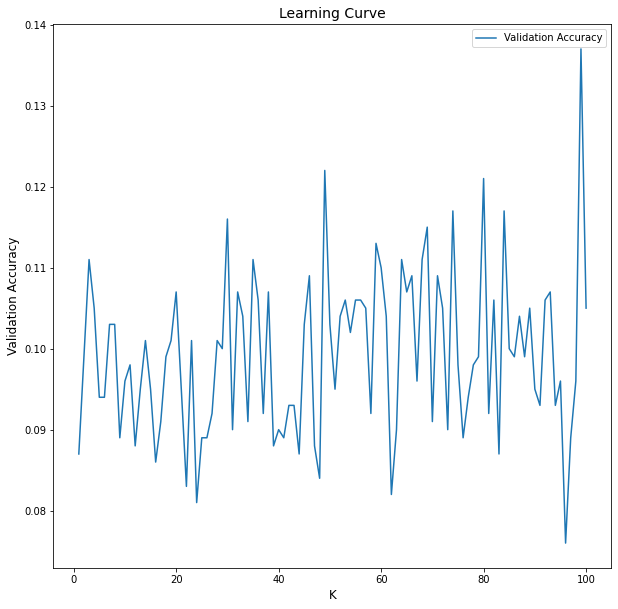

In [8]:
# The learning curve of the validation accuracy with different selection of k
plt.figure(figsize=(10, 10))
plt.title("Learning Curve", fontsize=14)
plt.xlabel("K", fontsize=12)
plt.ylabel("Validation Accuracy", fontsize=12)
plt.plot(np.array(range(1, 101)), config['axis_accuracy'], label="Validation Accuracy")
plt.legend()
plt.savefig('acc.jpg')